# Google Colab / Kaggle / PC

In [1]:
mode = "Colab"

In [2]:
import os

if mode == "Colab":
    from google.colab import drive
    drive.mount('/content/gdrive')
    os.chdir("/content/gdrive/My Drive/FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "PC":
    os.chdir("D:\PulpitE\FPL_ML")
    TRAIN_PATH = "data/final_dataset.csv"
if mode == "Kaggle":
    TRAIN_PATH = "/kaggle/input/fpl-dataset/final_dataset.csv"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imports

In [3]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [4]:
# FIXTURES_IN_SAMPLE
FIS = 8

# FIXTURES_FOR_PLAYER - minimal number of gameweeks required for a player
FFP = 15

FIRST_TRAIN_GW = 1
LAST_TRAIN_GW = 20

FIRST_VALID_GW = 21
LAST_VALID_GW = 21

# NEXT_GAMEWEEK = 22
# LAST_GAMEWEEK = NEXT_GAMEWEEK - 1

In [5]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Device

In [6]:
device = torch.device("cuda")
# device = torch.device('mps')
# device = torch.device('cpu')

# Getting data and choosing features

In [7]:
df = pd.read_csv('data/final_dataset.csv')

In [8]:
# remembering original dataframes
df_original = df

df_gk_original = df[df["FPL position"] == "GK"]
df_def_original = df[df["FPL position"] == "DEF"]
df_mid_original = df[df["FPL position"] == "MID"]
df_fwd_original = df[df["FPL position"] == "FWD"]

In [9]:
# df_original.columns

In [10]:
info = ["Name", "GW", "FPL position"]
other = ["LSTM"]
features = ["Min", "Gls", "Ast", "Sh", "SoT", "xG", "npxG", "xAG", "SCA", "GCA", "CS", "CrdY", "CrdR", "Opp rating", "Team Score", "Opp Score", "Was Home"]
to_predict = ["Total Points"]

In [11]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [12]:
df.shape

(7457, 21)

In [13]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')

# taking only players with at least FFP matches in logs
df = grouped.filter(lambda x: len(x) >= FFP)

In [14]:
df.shape

(5771, 21)

In [15]:
# df.head(20)

In [16]:
last_names = df["Name"].unique()

# DF to DataLoader

In [17]:
df_train = df[df["GW"] <= LAST_TRAIN_GW]
df_valid = df

# gk, def, mid, fwd
df_gk_train = df[(df["FPL position"] == "GK") & (df["GW"] <= LAST_TRAIN_GW)]
df_gk_valid = df[(df["FPL position"] == "GK") ]

df_def_train = df[(df["FPL position"] == "DEF") & (df["GW"] <= LAST_TRAIN_GW)]
df_def_valid = df[(df["FPL position"] == "DEF") ]

df_mid_train = df[(df["FPL position"] == "MID") & (df["GW"] <= LAST_TRAIN_GW)]
df_mid_valid = df[(df["FPL position"] == "MID") ]

df_fwd_train = df[(df["FPL position"] == "FWD") & (df["GW"] <= LAST_TRAIN_GW)]
df_fwd_valid = df[(df["FPL position"] == "FWD")]

In [18]:
def init_index_table(df):
    names = df["Name"].unique()
    result_dict = {}
    
    current_index = 0
    player_index = 0
    
    for name in names:
        sample_index = 0
        samples_for_names = df[df["Name"] == name].shape[0] - FIS
        for i in range(samples_for_names):
            result_dict[current_index] = [player_index, sample_index]
            current_index += 1
            sample_index += 1
        player_index += 1
    
    return result_dict

In [19]:
class PandasDataset(Dataset):
    def __init__(self, dataframe, starting_gw, ending_gw):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        
        self.starting_gw = starting_gw
        self.ending_gw = ending_gw
        self.cut_unused_rows()
        self.length = self.calculate_length()

        self.index_table = init_index_table(self.dataframe)
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def cut_unused_rows(self):
        for name in self.names:
            df_name = self.dataframe[self.dataframe["Name"] == name]
            name_length = df_name.shape[0]
            # print("NAME LENGTH", name, name_length, FIS + 1)
            if name_length >= FIS + 1:
                try:
                    first_index = df_name.index.tolist()[0]
                except IndexError:
                    first_index = None

                try:
                    last_index = max(FIS, df_name.index[df_name['GW'] < self.starting_gw].tolist()[-1]) - FIS
                except:
                    last_index = None

                # print("FIRST LAST INDEX", name, first_index, last_index)
                if first_index != None and last_index != None:
                    # print("WYCIETO", name, range(first_index, last_index + 1))
                    self.dataframe = self.dataframe.drop(range(first_index, last_index + 1))
            else:
                # print("DROPPING", name, [df_name.index.tolist()])
                self.dataframe = self.dataframe.drop([df_name.index.tolist()])
                

            # print("CUTTING", name, first_index, last_index, name_length)
            # print("CUT2", df_name.index[df_name['GW'] < self.starting_gw].tolist())
            # print(self.dataframe.shape)
            # print("")

    def calculate_length(self):
        length = 0
        for name in self.names:
            # print(name, (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS))
            length += (self.dataframe[self.dataframe["Name"] == name].shape[0] - FIS)
        return length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = self.index_table[idx]
        name = self.names[player_id]
        # print(name)
        # print("GETITEM DF", name, player_id, sample_id)

        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        # print("GETITEM", idx, player_id, sample_id, name)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [20]:
dataset_general_train = PandasDataset(df_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_general_valid = PandasDataset(df_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_gk_train = PandasDataset(df_gk_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_gk_valid = PandasDataset(df_gk_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_def_train = PandasDataset(df_def_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_def_valid = PandasDataset(df_def_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_mid_train = PandasDataset(df_mid_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_mid_valid = PandasDataset(df_mid_valid, FIRST_VALID_GW, LAST_VALID_GW)

dataset_fwd_train = PandasDataset(df_fwd_train, FIRST_TRAIN_GW, LAST_TRAIN_GW)
dataset_fwd_valid = PandasDataset(df_fwd_valid, FIRST_VALID_GW, LAST_VALID_GW)

In [21]:
dataset_gk_train.__len__(), dataset_gk_valid.__len__()

(280, 25)

In [22]:
dataset_def_train.__len__(), dataset_def_valid.__len__()

(1035, 100)

In [23]:
dataset_mid_train.__len__(), dataset_mid_valid.__len__()

(1346, 123)

In [24]:
dataset_fwd_train.__len__(), dataset_fwd_valid.__len__()

(326, 30)

In [25]:
batch_size = 16

In [26]:
dataloader_general_train = DataLoader(dataset_general_train, batch_size=batch_size, shuffle=False)
dataloader_general_valid = DataLoader(dataset_general_valid, batch_size=batch_size, shuffle=False)

dataloader_gk_train = DataLoader(dataset_gk_train, batch_size=batch_size, shuffle=False)
dataloader_def_train = DataLoader(dataset_def_train, batch_size=batch_size, shuffle=False)
dataloader_mid_train = DataLoader(dataset_mid_train, batch_size=batch_size, shuffle=False)
dataloader_fwd_train = DataLoader(dataset_fwd_train, batch_size=batch_size, shuffle=False)

dataloader_gk_valid = DataLoader(dataset_gk_valid, batch_size=batch_size, shuffle=False)
dataloader_def_valid = DataLoader(dataset_def_valid, batch_size=batch_size, shuffle=False)
dataloader_mid_valid = DataLoader(dataset_mid_valid, batch_size=batch_size, shuffle=False)
dataloader_fwd_valid = DataLoader(dataset_fwd_valid, batch_size=batch_size, shuffle=False)

In [27]:
len(dataloader_general_train), len(dataloader_gk_train), len(dataloader_def_train), len(dataloader_mid_train), len(dataloader_fwd_train)

(187, 18, 65, 85, 21)

In [28]:
len(dataloader_general_valid), len(dataloader_gk_valid), len(dataloader_def_valid), len(dataloader_mid_valid), len(dataloader_fwd_valid)

(18, 2, 7, 8, 2)

# LSTM Model

In [29]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

# Training loops

In [30]:
criterion = nn.MSELoss()

In [31]:
def train_net(net, num_epochs, dataloader_train, dataloader_valid, optimizer):
    if len(dataloader_train) <= 0:
        print("Dataloader has no elements")
        return []

    loss_history_train = []
    loss_history_valid = []

    for epoch in range(num_epochs):
        running_loss_train = 0
        running_loss_valid = 0

        # training
        for i, (inputs, targets) in enumerate(dataloader_train):
            inputs = torch.flatten(inputs, 1, 2)
            inputs = inputs.unsqueeze(2).to(device)
            targets = targets.to(device)
            # print("INPUTS", inputs.shape)
            # print("TARGETS", targets.shape)
            # print(targets)
            optimizer.zero_grad()
            outputs = net(inputs).flatten().to(device)
            # print("OUTPUTS", outputs.shape)
            loss = criterion(outputs, targets)
            running_loss_train += loss.item()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
          # valid
          for i, (inputs, targets) in enumerate(dataloader_valid):
              inputs = torch.flatten(inputs, 1, 2)
              inputs = inputs.unsqueeze(2).to(device)
              targets = targets.to(device)
              # print("INPUTS", inputs.shape)
              # print("TARGETS", targets.shape)
              # print(targets)
              optimizer.zero_grad()
              outputs = net(inputs).flatten().to(device)
              # print("OUTPUTS", outputs.shape)
              loss = criterion(outputs, targets)
              running_loss_valid += loss.item()

        loss_history_train.append(running_loss_train / len(dataloader_train))
        loss_history_valid.append(running_loss_valid / len(dataloader_valid))


        if epoch % 5 == 0:
            print(f'Epoch {epoch} Train: {running_loss_train / len(dataloader_train)} Valid: {running_loss_valid / len(dataloader_valid)}')
    
    return loss_history_train, loss_history_valid

In [32]:
def plot_loss_history(loss_history_train, loss_history_valid):
    plt.plot(loss_history_train, color='blue', label='Training Loss')
    plt.plot(loss_history_valid, color='orange', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Training loop - general net

In [33]:
%%time
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_history_train, loss_history_valid = train_net(net, 10, dataloader_general_train, dataloader_general_valid, optimizer)

Epoch 0 Train: 9.059177205524342 Valid: 8.710018104977078
Epoch 5 Train: 8.82690004677696 Valid: 8.724292172325981
CPU times: user 1min 13s, sys: 2.79 s, total: 1min 16s
Wall time: 1min 21s


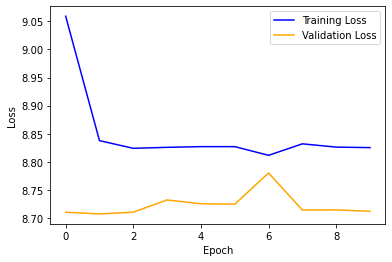

In [34]:
plot_loss_history(loss_history_train, loss_history_valid)

## Training loop - goalkeeper net

In [35]:
net_gk = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [36]:
%%time
optimizer_gk = optim.Adam(net_gk.parameters(), lr=0.01)
loss_history_gk_train, loss_history_gk_valid = train_net(net_gk, 5, dataloader_gk_train, dataloader_gk_valid, optimizer_gk)

Epoch 0 Train: 13.226041197776794 Valid: 13.61018180847168
CPU times: user 2.19 s, sys: 45 ms, total: 2.24 s
Wall time: 2.22 s


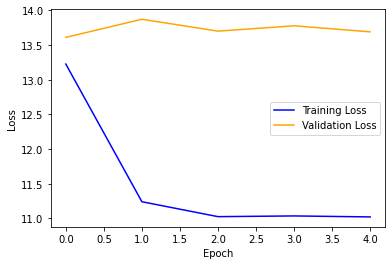

In [37]:
plot_loss_history(loss_history_gk_train, loss_history_gk_valid)

## Training loop - defender net

In [38]:
net_def = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [39]:
%%time
optimizer_def = optim.Adam(net_def.parameters(), lr=0.005)
loss_history_def_train, loss_history_def_valid = train_net(net_def, 5, dataloader_def_train, dataloader_def_valid, optimizer_def)

Epoch 0 Train: 8.86055102944374 Valid: 7.333229746137347
CPU times: user 10 s, sys: 99.8 ms, total: 10.1 s
Wall time: 10.1 s


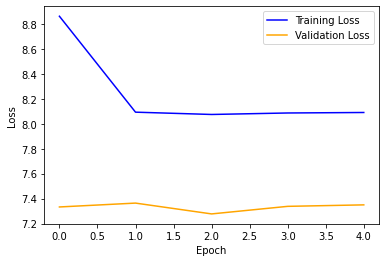

In [40]:
plot_loss_history(loss_history_def_train, loss_history_def_valid)

## Training loop - midfielder net

In [41]:
net_mid = LSTMNetwork(1, 20, 2, 1, dropout=0.4).to(device)

In [42]:
%%time
optimizer_mid = optim.Adam(net_mid.parameters(), lr=0.005)
loss_history_mid_train, loss_history_mid_valid = train_net(net_mid, 5, dataloader_mid_train, dataloader_mid_valid, optimizer_mid)

Epoch 0 Train: 9.194421863555908 Valid: 6.260515183210373
CPU times: user 14.3 s, sys: 121 ms, total: 14.4 s
Wall time: 15.2 s


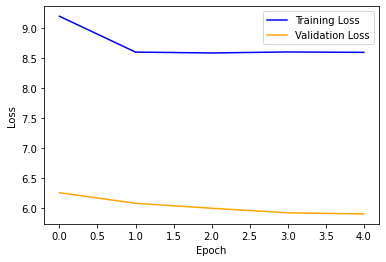

In [43]:
plot_loss_history(loss_history_mid_train, loss_history_mid_valid)

## Training loop - forward net

In [44]:
net_fwd = LSTMNetwork(1, 20, 2, 1, dropout=0.5).to(device)

In [ ]:
%%time
optimizer_fwd = optim.Adam(net_fwd.parameters(), lr=0.001)
loss_history_fwd_train, loss_history_fwd_valid = train_net(net_fwd, 1200, dataloader_fwd_train, dataloader_fwd_valid, optimizer_fwd)

Epoch 0 Train: 17.357076031821116 Valid: 22.564244270324707
Epoch 5 Train: 10.524856317610968 Valid: 14.645283222198486
Epoch 10 Train: 10.4532440276373 Valid: 14.892630100250244
Epoch 15 Train: 10.47334200995309 Valid: 14.792520523071289
Epoch 20 Train: 10.500282980146862 Valid: 14.9645414352417
Epoch 25 Train: 10.49298213777088 Valid: 14.729052066802979
Epoch 30 Train: 10.462480000087194 Valid: 14.587857246398926
Epoch 35 Train: 10.414281527201334 Valid: 14.350034236907959
Epoch 40 Train: 10.017047984259468 Valid: 13.729156017303467
Epoch 45 Train: 9.907097192037673 Valid: 13.159412384033203
Epoch 50 Train: 9.6980299949646 Valid: 13.258057117462158
Epoch 55 Train: 9.640098662603469 Valid: 13.039016723632812
Epoch 60 Train: 9.852649030231294 Valid: 12.88828420639038
Epoch 65 Train: 9.568907374427432 Valid: 12.221688747406006
Epoch 70 Train: 9.668433518636794 Valid: 13.23386812210083
Epoch 75 Train: 9.496407446407137 Valid: 12.814807415008545
Epoch 80 Train: 9.430510577701387 Valid: 12

In [ ]:
plot_loss_history(loss_history_fwd_train, loss_history_fwd_valid)

# Metrics

In [ ]:
# general model


# Saving models to files

In [ ]:
# general model
torch.save(net.state_dict(), 'models/lstm_general.pt')

# positional models
torch.save(net_gk.state_dict(), 'models/lstm_gk.pt')
torch.save(net_def.state_dict(), 'models/lstm_def.pt')
torch.save(net_mid.state_dict(), 'models/lstm_mid.pt')
torch.save(net_fwd.state_dict(), 'models/lstm_fwd.pt')

# Predictions - general model

In [ ]:
def generate_predictions(dataloader_pos, dataset_pos, net_pos, df_original, first_gw):
    index = 0
    predictions_pos = []
    for inputs, target in dataloader_pos:
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2).to(device)

        # print("Inputs", inputs)
        # print("Target", target)
        # print("INPUTS", inputs)
        # print(inputs)
        outputs = net_pos(inputs).to(device)
        # print("OUTPUTS", outputs)
        for output in outputs:
            player_id, sample_id = dataset_pos.index_table[index]
            name = dataset_pos.names[player_id]
            points = round(output.item(), 2)
            # print("DFORW NEXT", player_id, sample_id, name, points)
            df_row = df_original[(df_original["Name"] == name) & (df_original["GW"] >= first_gw)].iloc[sample_id]
            # print("DFROW", df_row)
            df_row["Points"] = points
            df_gw = df_row["GW"]
            df_opp = df_row["Opponent"]

            # print("GEN PRED", player_id, sample_id, name, points, df_gw, df_opp)
            
            gw = sample_id + FIS + 1 # wrong
            predictions_pos.append(df_row)
            # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
            index += 1
    
    output_df = pd.DataFrame(predictions_pos)
    output_df = output_df.loc[:, ~output_df.columns.str.contains('^Unnamed')]
    return output_df

In [ ]:
prediction_columns = ["Name", "GW", "Opponent", "Was Home", "Total Points", "Points"]

In [ ]:
predictions = generate_predictions(dataloader_general_valid, dataset_general_valid, net, df_original, FIRST_VALID_GW)

In [ ]:
# dataset_general_valid.__getitem__(279)

In [ ]:
predictions.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

In [ ]:
# # appending results to original df
# for df_gw, df_opp, name, gw, points in predictions:
#     df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [ ]:
# df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

# Predictions for each position

## Goalkeepers

In [ ]:
predictions_gk = generate_predictions(dataloader_gk_valid, dataset_gk_valid, net_gk, df_gk_original, FIRST_VALID_GW)

In [ ]:
# results sorted
predictions_gk.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

## Defenders

In [ ]:
predictions_def = generate_predictions(dataloader_def_valid, dataset_def_valid, net_def, df_def_original, FIRST_VALID_GW)

In [ ]:
# results sorted
predictions_def.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

## Midfielders

In [ ]:
predictions_mid = generate_predictions(dataloader_mid_valid, dataset_mid_valid, net_mid, df_mid_original, FIRST_VALID_GW)

In [ ]:
# results sorted
predictions_mid.sort_values(by=["Points"], ascending = False).head(20)[prediction_columns]

## Forwards

In [ ]:
predictions_fwd = generate_predictions(dataloader_fwd_valid, dataset_fwd_valid, net_fwd, df_fwd_original, FIRST_VALID_GW)

In [ ]:
# results sorted
predictions_fwd.sort_values(by=["Points"], ascending = False).head(30)[prediction_columns]